# **Community Prediction and Recommendation on Social Media Data**

> Indented block




In [ ]:
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


In [ ]:
!pip install torch-geometric
!pip install ogb  # for datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 948.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=cfc63f7fa4a23c7da442d327b76702ddc75088d52f180d2b544a22276b854c5f
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
from torch_geometric.datasets.snap_dataset import SNAPDataset
import torch_geometric

## Preprocessing

In [ ]:
from torch_geometric.data import Data
from torch_geometric import nn
import torch_geometric.transforms as T

In [ ]:
# train/test/validation split
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05,  # ratio of edges including in the validation set
                      num_test=0.2,  # ratio of edges including in the test set
                      is_undirected=True,
                      add_negative_train_samples=False),
])

In [ ]:
initial_datasets = SNAPDataset(root='/tmp/SNAPDataset', name='ego-gplus')

Extracting /tmp/SNAPDataset/ego-gplus/raw/gplus.tar.gz
Processing...
Done!


#### Adding Random Embeddings

In [ ]:
from torch_geometric.data import InMemoryDataset, Data

class CustomDataset(InMemoryDataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__(None)  # Provide a dummy path
        self.data_list = data_list

        self.data, self.slices = self.collate(data_list)

        self._store = data_list[0]
        self.is_bipartite = False

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [ ]:
tensor_length = 1692
embedding_size = 10
random_tensor = torch.rand(tensor_length, embedding_size)

remb_datasets = []

for dataset in initial_datasets:
    remb_dataset = Data(x=random_tensor, edge_index=dataset.edge_index)
    remb_dataset.num_features = embedding_size
    remb_datasets.append(remb_dataset)

remb_datasets = CustomDataset(remb_datasets)

remb_datasets[0]

Data(x=[1692, 10], edge_index=[2, 169674], num_features=10)

#### Train/Test Split

In [ ]:
train_data, val_data, test_data = transform(remb_datasets[0])

## Basic Graph Info

In [ ]:
def get_n_neighbors(graph, idx):
  # takes a Data object, an index of a node, and returns the number of the neighbors
  # of this node (as an integer).
  return int(torch_geometric.utils.degree(graph.edge_index[0], graph.num_nodes)[idx])

def get_max_degree(graph):
  num_nodes = graph.num_nodes

  degrees = [get_n_neighbors(graph, i) for i in range(num_nodes)]

  return max(degrees)


def get_min_degree(graph):
  num_nodes = graph.num_nodes

  degrees = [get_n_neighbors(graph, i) for i in range(num_nodes)]

  return min(degrees)

## Edge Prediction with Message-Passing GNN

### Pipeline

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self, node_feature, edge_index):

        output = self.conv1(node_feature, edge_index)
        output = self.act(output)
        output = self.conv2(output, edge_index)

        return output

In [ ]:
# initialize GCN
model = GCN(train_data.num_features, hidden_channels=128, out_channels=64)

In [ ]:
# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
# define loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

### Negative Sampling

In [ ]:
from torch_geometric.utils import negative_sampling

neg_edge_index = negative_sampling(
      edge_index=train_data.edge_index,  # positive edges in the graph
      num_nodes=train_data.num_nodes,  # number of nodes
      num_neg_samples=5,  # number of negative examples
    )

print("shape of neg_edge_index:", neg_edge_index.shape)  # [2, num_neg_samples]
print("negative examples:", neg_edge_index)

shape of neg_edge_index: torch.Size([2, 5])
negative examples: tensor([[ 715, 1633,  909, 1618, 1187],
        [ 510,  679, 1520,  227,  126]])


### Defining Similarity

In [ ]:
import numpy as np

def compute_similarity(node_embs, edge_index):
    # calculate the inner product between all the pairs in the edge_index
    # Note: the shape of node_embs is [n, h] where n is the number of nodes, and h is the embedding size
    # the shape of edge_index is [2, m] where m is the number of edges

    return torch.sum(node_embs[edge_index[0]] * node_embs[edge_index[1]], dim=1)

n, h = 5, 10  # number of nodes and embedding size
node_embs = torch.rand(n, h)
edge_index = torch.tensor([[0, 1, 2, 3],
                           [2, 3, 0, 1]])  # compute the similarity of (0, 2), (1, 3), (2, 0), (3, 1)
similarity = compute_similarity(node_embs, edge_index)
print("Similarity:", similarity)

Similarity: tensor([2.6290, 2.1213, 2.6290, 2.1213])


### Positive Sampling

In [ ]:
print("positive examples' labels:", train_data.edge_label)

positive examples' labels: tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [ ]:
def train(model, data, optimizer, loss_fn):

    loss = 0

    # TODO: Define train function.
    # 1. put the model into train mode
    # 2. clear the gradients calculated from the last batch
    # 3. use 'edge_index' to get the node representation by model
    # 4. sample the negative examples with the same number of positive ones (edge_label_index)
    # 5. concatenate the positive edges and negative edges
    # 6. concatenate the labels of positive edges and negative edges
    # 7. calculate the similarity between two end nodes to determine the probability that the corresponding edge is present on the graph.
    # 8. feed the probability and edge label to the loss function
    # 9. calculate the gradients of each parameter
    # 10. update the parameters by taking an optimizer step

    ############# Your code here ############
    model.train()
    optimizer.zero_grad()
    node_embs = model(data.x, data.edge_index)
    negative_edge_index = negative_sampling(data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.num_edges)
    all_edges = torch.cat([data.edge_index, negative_edge_index], dim=1)
    all_labels = torch.cat([torch.ones(data.num_edges), torch.zeros(negative_edge_index.size(1))])
    edge_similarity = compute_similarity(node_embs, all_edges)
    loss = loss_fn(edge_similarity, all_labels)
    loss.backward()
    optimizer.step()
    loss = loss.item()

    #########################################

    return loss

In [ ]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # use `edge_index` to perform message passing
    out = compute_similarity(out, data.edge_label_index).view(-1).sigmoid()  # use `edge_label_index` to compute the loss
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
epochs = 100

epoch_loss=[]
epoch_val=[]
epoch_test=[]

best_val_auc = final_test_auc = 0
for epoch in range(1, epochs + 1):
    loss = train(model, train_data, optimizer, loss_fn)
    valid_auc = test(model, val_data)
    test_auc = test(model, test_data)
    if valid_auc > best_val_auc:
        best_val_auc = valid_auc
        final_test_auc = test_auc
    if(epoch%5==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_auc:.4f}, Test: {test_auc:.4f}')

    epoch_loss.append(loss)
    epoch_val.append(valid_auc)
    epoch_test.append(test_auc)

Epoch: 005, Loss: 0.5625, Val: 0.8452, Test: 0.8485
Epoch: 010, Loss: 0.5633, Val: 0.8549, Test: 0.8581
Epoch: 015, Loss: 0.5639, Val: 0.8527, Test: 0.8557
Epoch: 020, Loss: 0.5635, Val: 0.8456, Test: 0.8489
Epoch: 025, Loss: 0.5621, Val: 0.8464, Test: 0.8496
Epoch: 030, Loss: 0.5627, Val: 0.8493, Test: 0.8530
Epoch: 035, Loss: 0.5642, Val: 0.8269, Test: 0.8297
Epoch: 040, Loss: 0.5765, Val: 0.8564, Test: 0.8584
Epoch: 045, Loss: 0.5786, Val: 0.8487, Test: 0.8494
Epoch: 050, Loss: 0.5716, Val: 0.8584, Test: 0.8610
Epoch: 055, Loss: 0.5786, Val: 0.8506, Test: 0.8521
Epoch: 060, Loss: 0.5712, Val: 0.8511, Test: 0.8532
Epoch: 065, Loss: 0.5684, Val: 0.8498, Test: 0.8529
Epoch: 070, Loss: 0.5664, Val: 0.8511, Test: 0.8536
Epoch: 075, Loss: 0.5664, Val: 0.8480, Test: 0.8499
Epoch: 080, Loss: 0.5652, Val: 0.8458, Test: 0.8485
Epoch: 085, Loss: 0.5684, Val: 0.8279, Test: 0.8294
Epoch: 090, Loss: 0.5699, Val: 0.8476, Test: 0.8489
Epoch: 095, Loss: 0.5695, Val: 0.8444, Test: 0.8459
Epoch: 100, 

### Plots

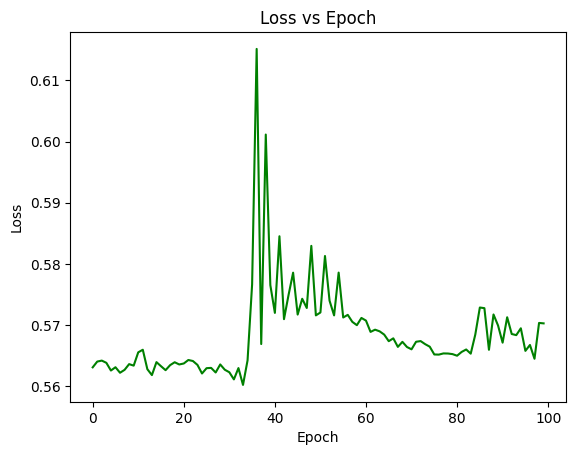

In [ ]:
import matplotlib.pyplot as plt

plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(epoch_loss)), epoch_loss, color ="green")
plt.show()

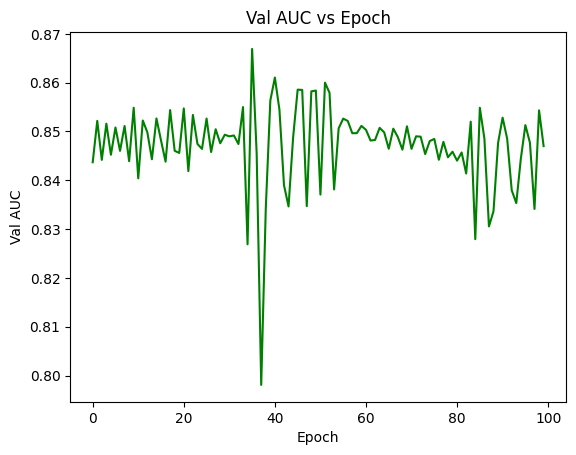

In [ ]:
plt.title("Val AUC vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Val AUC")
plt.plot(range(len(epoch_val)), epoch_val, color ="green")
plt.show()

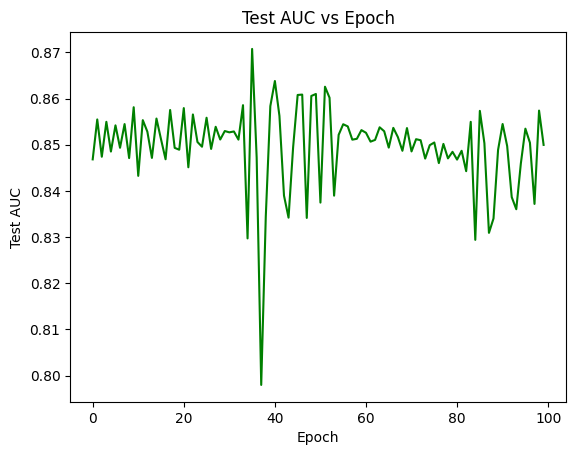

In [ ]:
plt.title("Test AUC vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test AUC")
plt.plot(range(len(epoch_test)), epoch_test, color ="green")
plt.show()

### Evaluation Plots

Source: https://towardsdatascience.com/visualize-machine-learning-metrics-like-a-pro-b0d5d7815065

In [ ]:
node_emb = model(test_data.x, test_data.edge_index)
negative_edge_index = negative_sampling(
        edge_index=test_data.edge_index,
        num_nodes=test_data.num_nodes,
        num_neg_samples=test_data.edge_label_index.shape[1]
)
labels = torch.cat([torch.ones(test_data.edge_label_index.shape[1]),torch.zeros(negative_edge_index.shape[1])])
edge_index = torch.cat([test_data.edge_label_index, negative_edge_index], dim=1)

similarity = compute_similarity(node_emb, edge_index)

print(len(similarity), len(labels))

65976 65976


Now, we use the node embeddings on the test set to get a probability of prediction for each, and make various diagnostic plots for our model

In [ ]:
# make the plots better below by using softmax?
labels = labels

similarity_np = similarity.detach().numpy()

similarity_np = (similarity_np-np.mean(similarity_np))/np.max(similarity_np)
similarity_np = (similarity_np+1)/2
similarity_np_pred = np.rint(similarity_np)

print(similarity_np)

[0.48696807 0.56228477 0.63857317 ... 0.4820435  0.45890957 0.4818781 ]


#### Diagnostic Plots

In [ ]:
!pip install scikit-plot==0.3.7
import scikitplot as skplt

In [ ]:
similarity = similarity_np
similarity_pred = similarity_np_pred

<Axes: title={'center': 'Confusion Matrix for GBC'}, xlabel='Predicted label', ylabel='True label'>

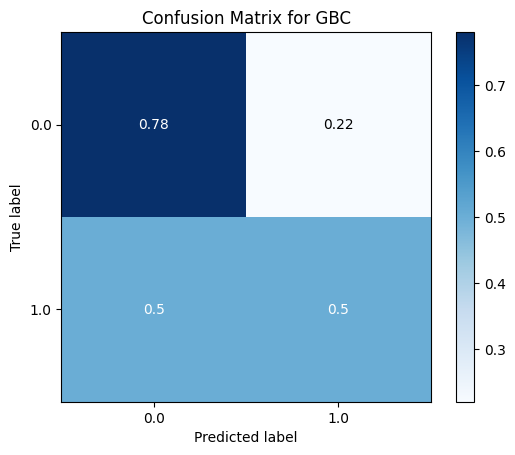

In [ ]:
skplt.metrics.plot_confusion_matrix(labels, similarity_pred, normalize=True, title = 'Confusion Matrix for GBC')